In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import xgboost
from xgboost import XGBRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict


In [10]:
df = pd.read_csv('Superstore.csv')

In [11]:
df_model = df.drop(columns=["Country", "City", "Postal Code", "Ship Mode"])

# One-hot encode categorical variables
df_encoded = pd.get_dummies(df_model, columns=["Category", "Sub-Category", "Segment",  "State","Region"], drop_first=True)

# Display the first few rows of the encoded dataset
df_encoded.head()

,Sales,Quantity,Discount,Profit,Category_Office Supplies,Category_Technology,Sub-Category_Appliances,Sub-Category_Art,Sub-Category_Binders,Sub-Category_Bookcases,...,State_Utah,State_Vermont,State_Virginia,State_Washington,State_West Virginia,State_Wisconsin,State_Wyoming,Region_East,Region_South,Region_West
0,261.9600,2,0.00,41.9136,False,False,False,False,False,True,...,False,False,False,False,False,False,False,False,True,False
1,731.9400,3,0.00,219.5820,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,14.6200,2,0.00,6.8714,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,True
3,957.5775,5,0.45,-383.0310,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,22.3680,2,0.20,2.5164,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [12]:
X = df_encoded.drop(columns=["Profit"])
y = df_encoded["Profit"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:

# Initialize the model
gb_model = XGBRegressor(
    random_state=42,
    n_estimators=30,
    learning_rate=0.1,
    max_depth=3
)

# Fit the model on the training data
gb_model.fit(X_train, y_train)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=30,
             n_jobs=None, num_parallel_tree=None, ...)

In [14]:
y_pred = gb_model.predict(X_test)

# Evaluate model performance
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

# Print the results
print(f"R²: {r2:.3f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

R²: 0.445
RMSE: 164.10
MAE: 48.91


In [16]:
cv_scores = cross_val_score(gb_model, X, y, cv=4)
print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())

Cross-validation scores: [0.71468602 0.6950912  0.57544837 0.64025122]
Mean CV score: 0.6563692040604032


## PROFIT PREDICTIONS_____________________________________________________________________________________________________

In [17]:
# Next up, we'll try making profit predictions using our trained model.

In [18]:
# First up, let's get our encoded data set to respond to it's original column names.
# This code will group up our encoded columns under their old labels so our trained model is able to recognise them.

def simulate_profit(
    df,
    trained_model,
    model_features,
    category=None,
    region=None,
    sub_category=None,
    Segment=None,
    discount=0.15
):
    """
    Simulates predicted profit using a trained model on filtered original data.

    Parameters:
    - df: Original unencoded DataFrame
    - trained_model: A fitted regression model (e.g., GradientBoostingRegressor)
    - model_features: List of features used to train the model
    - category: Optional filter for Category (e.g., "Furniture")
    - region: Optional filter for Region (e.g., "Central")
    - sub_category: Optional filter for Sub-Category (e.g., "Chairs")
    - discount: Discount value to apply (e.g., 0.1 for 10%)

    Returns:
    - Dictionary with total and average predicted profit
    """
    df_filtered = df.copy()

    # Apply filters
    if category:
        df_filtered = df_filtered[df_filtered["Category"] == category]
    if region:
        df_filtered = df_filtered[df_filtered["Region"] == region]
    if sub_category:
        df_filtered = df_filtered[df_filtered["Sub-Category"] == sub_category]
    if Segment:
        df_filtered = df_filtered[df_filtered["Segment"] == Segment]

    if df_filtered.empty:
        return {"message": "No data matches the given filters."}

    # Apply discount logic
    if isinstance(discount, dict):
        def apply_custom_discount(row):
            subcat = row["Sub-Category"]
            current_discount = row["Discount"]
            cap = discount.get(subcat, current_discount)
            return min(current_discount, cap)
        df_filtered["Discount"] = df_filtered.apply(apply_custom_discount, axis=1)
    else:
        df_filtered["Discount"] = df_filtered["Discount"].apply(lambda x: min(x, discount))

    # Drop unused columns
    df_filtered = df_filtered.drop(columns=["Country", "City", "Postal Code", "Ship Mode"])

    # One-hot encode the filtered data
    df_encoded = pd.get_dummies(df_filtered, columns=["Category", "Sub-Category", "Segment", "State", "Region"], drop_first=True)

    # 🛠 PATCH: Add any missing features the model was trained on
    for col in model_features:
        if col not in df_encoded.columns:
            df_encoded[col] = 0

    # Reorder columns to match training
    df_encoded = df_encoded[model_features]

    # Predict
    predicted = trained_model.predict(df_encoded)

    return {
        "Total Predicted Profit": round(predicted.sum(), 2),
        "Average Profit per Order": round(predicted.mean(), 2),
        "Num Orders": len(predicted)
    }


In [19]:
# Great! and with that, we are able to start making our projections on what our profits would look like with our proposed discount caps.

## GENERAL PREDICTIONS

In [20]:
# In this section, we will be looking at predictions in a general view.

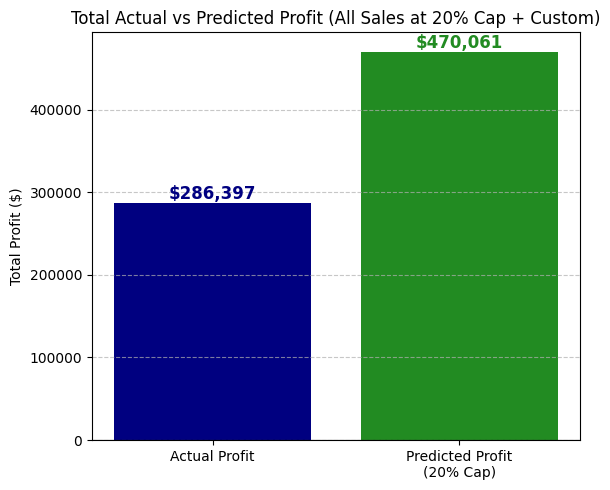

In [ ]:
# Let's start simple with the actual vs predicted total profits.

# Set discount level for simulation
discount_level = 0.2

custom_overrides = {
    "Chairs": 0.1,
    "Bookcases": 0.1,
    "Supplies": 0.1,
    "Storage": 0.1,
    "Machines": 0.1
}

# Build full discount dictionary: apply overrides + fallback to discount_level
subcategories = df["Sub-Category"].unique()
custom_discounts = {
    subcat: custom_overrides.get(subcat, discount_level)
    for subcat in subcategories
}
# Actual total profit
actual_total_profit = df["Profit"].sum()

# Predicted total profit
predicted = simulate_profit(
    df=df,
    trained_model=gb_model,
    model_features=X_train.columns.tolist(),
    discount=custom_discounts
)
predicted_total_profit = predicted["Total Predicted Profit"] if "Total Predicted Profit" in predicted else 0



# Bar chart data
labels = ["Actual Profit", f"Predicted Profit\n({int(discount_level*100)}% Cap)"]
values = [actual_total_profit, predicted_total_profit]

# Plot
plt.figure(figsize=(6, 5))
bars = plt.bar(labels, values, color=["Navy", "ForestGreen"])

# Annotate bars
for bar, color in zip(bars, ["Navy", "ForestGreen"]):
    height = bar.get_height()
    offset = 5 if height >= 0 else -5
    va = 'bottom' if height >= 0 else 'top'
    plt.text(bar.get_x() + bar.get_width()/2, height + offset, f"${height:,.0f}",
             ha='center', va=va, fontsize=12, color=color, fontweight="bold")

# Styling
plt.ylabel("Total Profit ($)")
plt.title("Total Actual vs Predicted Profit (All Sales at 20% Cap + Custom)")
plt.axhline(0, color='black', linewidth=0.8)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


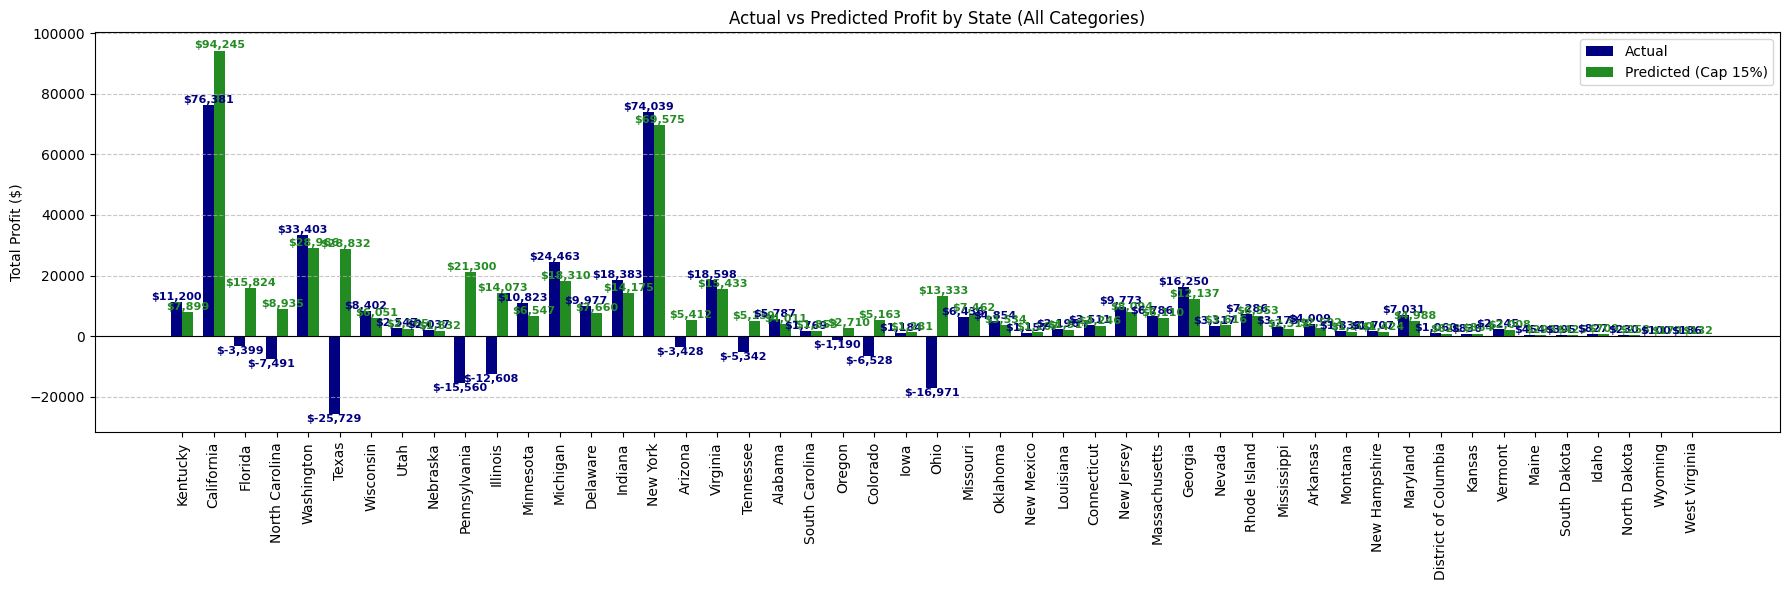

In [22]:
# First up let's look at actual vs predicted profits in all states.

# Set discount level for simulation
discount_level = 0.15

custom_overrides = {
    "Chairs": 0.1,
    "Bookcases": 0.1,
    "Supplies": 0.1,
    "Storage": 0.1,
    "Machines": 0.1,
    "Appliances": 0.1
}

# Build full discount dictionary: apply overrides + fallback to discount_level
subcategories = df["Sub-Category"].unique()
custom_discounts = {
    subcat: custom_overrides.get(subcat, discount_level)
    for subcat in subcategories
}

# Get unique states
states = df["State"].unique()

# Store results
actual_profits = []
predicted_profits = []

for state in states:
    # Actual profit
    df_actual = df[df["State"] == state]
    actual_profit = df_actual["Profit"].sum()
    actual_profits.append(actual_profit)

    # Predicted profit with discount cap
    predicted = simulate_profit(
        df=df[df["State"] == state],
        trained_model=gb_model,
        model_features=X_train.columns.tolist(),
        discount=custom_discounts
    )

    if "Total Predicted Profit" in predicted:
        predicted_profits.append(predicted["Total Predicted Profit"])
    else:
        predicted_profits.append(0)

# Create bar positions
x = np.arange(len(states))
bar_width = 0.35

# Plot
plt.figure(figsize=(18, 6))
bars1 = plt.bar(x - bar_width/2, actual_profits, width=bar_width, color="Navy", label="Actual")
bars2 = plt.bar(x + bar_width/2, predicted_profits, width=bar_width, color="ForestGreen", label=f"Predicted (Cap {int(discount_level*100)}%)")



# Annotate bars
for i in range(len(states)):
    for bar, color in zip([bars1[i], bars2[i]], ["Navy", "ForestGreen"]):
        height = bar.get_height()
        offset = 5 if height >= 0 else -5
        va = 'bottom' if height >= 0 else 'top'
        plt.text(bar.get_x() + bar.get_width()/2, height + offset, f"${height:,.0f}",
                 ha='center', va=va, fontsize=8, color=color, fontweight="bold")

# Final touches
plt.xticks(x, states, rotation=90)
plt.ylabel("Total Profit ($)")
plt.title("Actual vs Predicted Profit by State (All Categories)")
plt.axhline(0, color='black', linewidth=0.8)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [23]:
# Interesting, all loss making states make significant profits, but some profit making states are predicted to make less profits. 

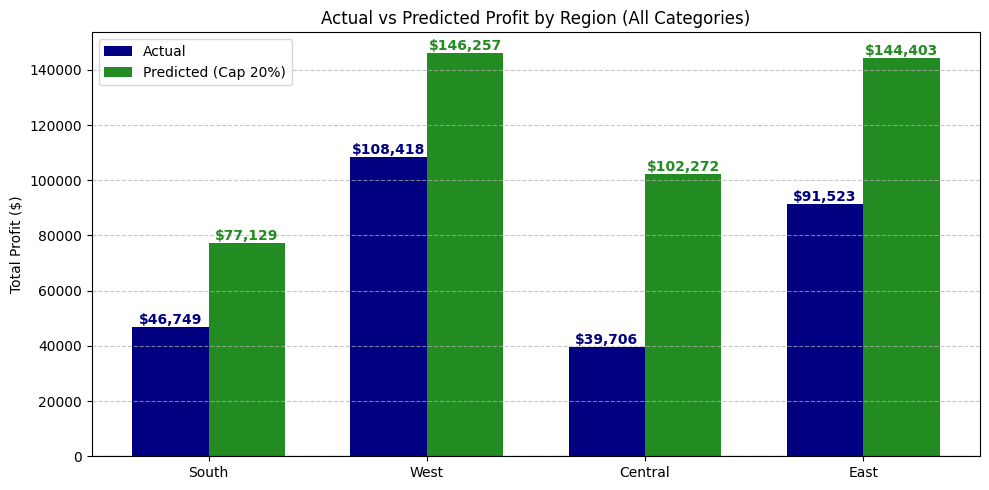

In [24]:
# Next up, let's look at actual vs predicted profits at the regional level.
# Set discount level for simulation
discount_level = 0.2

custom_overrides = {
    "Chairs": 0.1,
    "Bookcases": 0.1,
    "Supplies": 0.1,
    "Storage": 0.1,
    "Machines": 0.1
}

# Build full discount dictionary: apply overrides + fallback to discount_level
subcategories = df["Sub-Category"].unique()
custom_discounts = {
    subcat: custom_overrides.get(subcat, discount_level)
    for subcat in subcategories
}

# Get unique regions
regions = df["Region"].unique()

# Store results
actual_profits = []
predicted_profits = []

for region in regions:
    # Actual profit
    df_actual = df[df["Region"] == region]
    actual_profit = df_actual["Profit"].sum()
    actual_profits.append(actual_profit)

    # Predicted profit with discount cap
    predicted = simulate_profit(
        df=df[df["Region"] == region],
        trained_model=gb_model,
        model_features=X_train.columns.tolist(),
        discount=custom_discounts
    )

    if "Total Predicted Profit" in predicted:
        predicted_profits.append(predicted["Total Predicted Profit"])
    else:
        predicted_profits.append(0)

# Create bar positions
x = np.arange(len(regions))
bar_width = 0.35

# Plot
plt.figure(figsize=(10, 5))
bars1 = plt.bar(x - bar_width/2, actual_profits, width=bar_width, color="Navy", label="Actual")
bars2 = plt.bar(x + bar_width/2, predicted_profits, width=bar_width, color="ForestGreen", label=f"Predicted (Cap {int(discount_level*100)}%)")

# Annotate bars
for i in range(len(regions)):
    for bar, color in zip([bars1[i], bars2[i]], ["Navy", "ForestGreen"]):
        height = bar.get_height()
        offset = 5 if height >= 0 else -5
        va = 'bottom' if height >= 0 else 'top'
        plt.text(bar.get_x() + bar.get_width()/2, height + offset, f"${height:,.0f}",
                 ha='center', va=va, fontsize=10, color=color, fontweight="bold")

# Final touches
plt.xticks(x, regions)
plt.ylabel("Total Profit ($)")
plt.title("Actual vs Predicted Profit by Region (All Categories)")
plt.axhline(0, color='black', linewidth=0.8)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [25]:
# It's looking much better at a regional level. There's a sold improvement in all areas. 

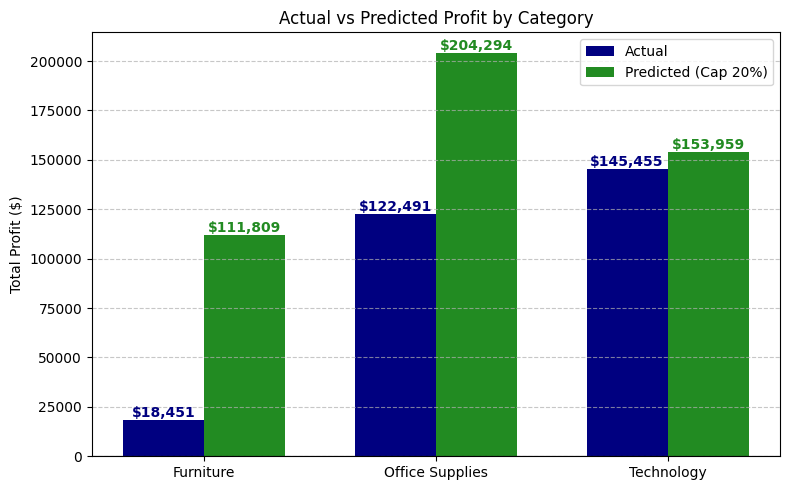

In [26]:
# Next up, at the category level.

# Set discount level for simulation
discount_level = 0.2

# Set custom discount levels for our special target sub categories.
custom_overrides = {
    "Chairs": 0.1,
    "Bookcases": 0.1,
    "Supplies": 0.1,
    "Storage": 0.1,
    "Machines": 0.1
}

# Build full discount dictionary: apply overrides + fallback to discount_level
subcategories = df["Sub-Category"].unique()
custom_discounts = {
    subcat: custom_overrides.get(subcat, discount_level)
    for subcat in subcategories
}

# Get unique categories
categories = df["Category"].unique()

# Store results
actual_profits = []
predicted_profits = []

for category in categories:
    # Actual profit
    df_actual = df[df["Category"] == category]
    actual_profit = df_actual["Profit"].sum()
    actual_profits.append(actual_profit)

    # Predicted profit
    predicted = simulate_profit(
        df=df[df["Category"] == category],
        trained_model=gb_model,
        model_features=X_train.columns.tolist(),
        category=category,
        discount=custom_discounts
    )

    if "Total Predicted Profit" in predicted:
        predicted_profits.append(predicted["Total Predicted Profit"])
    else:
        predicted_profits.append(0)

# Create bar positions
x = np.arange(len(categories))
bar_width = 0.35

# Plot
plt.figure(figsize=(8, 5))
bars1 = plt.bar(x - bar_width/2, actual_profits, width=bar_width, color="Navy", label="Actual")
bars2 = plt.bar(x + bar_width/2, predicted_profits, width=bar_width, color="ForestGreen", label=f"Predicted (Cap {int(discount_level*100)}%)")

# Annotate bars
for i in range(len(categories)):
    for bar, color in zip([bars1[i], bars2[i]], ["Navy", "ForestGreen"]):
        height = bar.get_height()
        offset = 5 if height >= 0 else -5
        va = 'bottom' if height >= 0 else 'top'
        plt.text(bar.get_x() + bar.get_width()/2, height + offset, f"${height:,.0f}",
                 ha='center', va=va, fontsize=10, color=color, fontweight="bold")

# Final touches
plt.xticks(x, categories)
plt.ylabel("Total Profit ($)")
plt.title("Actual vs Predicted Profit by Category")
plt.axhline(0, color='black', linewidth=0.8)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


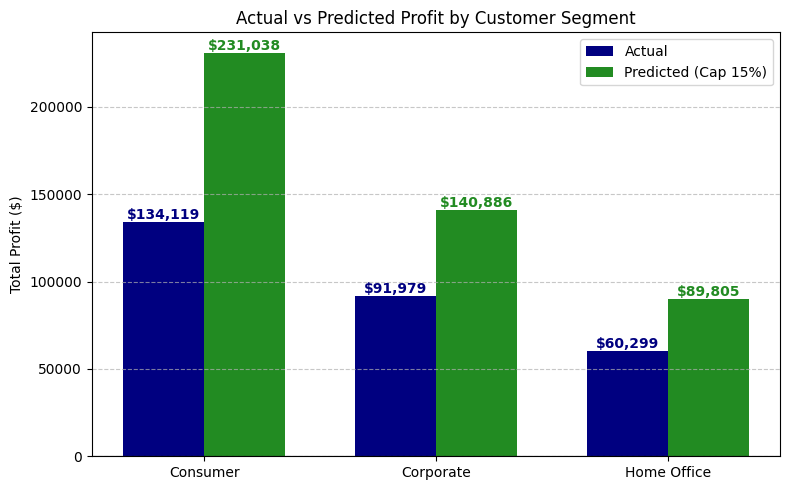

In [27]:
# Now for our final geneal view, the customer segments.
# Set discount level for simulation
discount_level = 0.15


# Set custom discount levels for our special target sub categories.
custom_overrides = {
    "Chairs": 0.15,
    "Bookcases": 0.1,
    "Supplies": 0.1,
    "Storage": 0.1,
    "Machines": 0.1
}

# Build full discount dictionary: apply overrides + fallback to discount_level
subcategories = df["Sub-Category"].unique()
custom_discounts = {
    subcat: custom_overrides.get(subcat, discount_level)
    for subcat in subcategories
}

# Get unique customer segments
segments = df["Segment"].unique()

# Store results
actual_profits = []
predicted_profits = []

for segment in segments:
    # Actual profit
    df_actual = df[df["Segment"] == segment]
    actual_profit = df_actual["Profit"].sum()
    actual_profits.append(actual_profit)

    # Predicted profit
    predicted = simulate_profit(
        df=df[df["Segment"] == segment],
        trained_model=gb_model,
        model_features=X_train.columns.tolist(),
        Segment=segment,
        discount=custom_discounts
    )

    if "Total Predicted Profit" in predicted:
        predicted_profits.append(predicted["Total Predicted Profit"])
    else:
        predicted_profits.append(0)

# Create bar positions
x = np.arange(len(segments))
bar_width = 0.35

# Plot
plt.figure(figsize=(8, 5))
bars1 = plt.bar(x - bar_width/2, actual_profits, width=bar_width, color="Navy", label="Actual")
bars2 = plt.bar(x + bar_width/2, predicted_profits, width=bar_width, color="ForestGreen", label=f"Predicted (Cap {int(discount_level*100)}%)")

# Annotate bars
for i in range(len(segments)):
    for bar, color in zip([bars1[i], bars2[i]], ["Navy", "ForestGreen"]):
        height = bar.get_height()
        offset = 5 if height >= 0 else -5
        va = 'bottom' if height >= 0 else 'top'
        plt.text(bar.get_x() + bar.get_width()/2, height + offset, f"${height:,.0f}",
                 ha='center', va=va, fontsize=10, color=color, fontweight="bold")

# Final touches
plt.xticks(x, segments)
plt.ylabel("Total Profit ($)")
plt.title("Actual vs Predicted Profit by Customer Segment")
plt.axhline(0, color='black', linewidth=0.8)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



In [28]:
# And that wraps it up for our general view. Up next, let's take a look by Category
# In all our categories we will be looking at actual vs predicted profits by State, Region, Subcategory and Segment.

## FURNITURE________________________________________________________________________________________________________________________________________________________

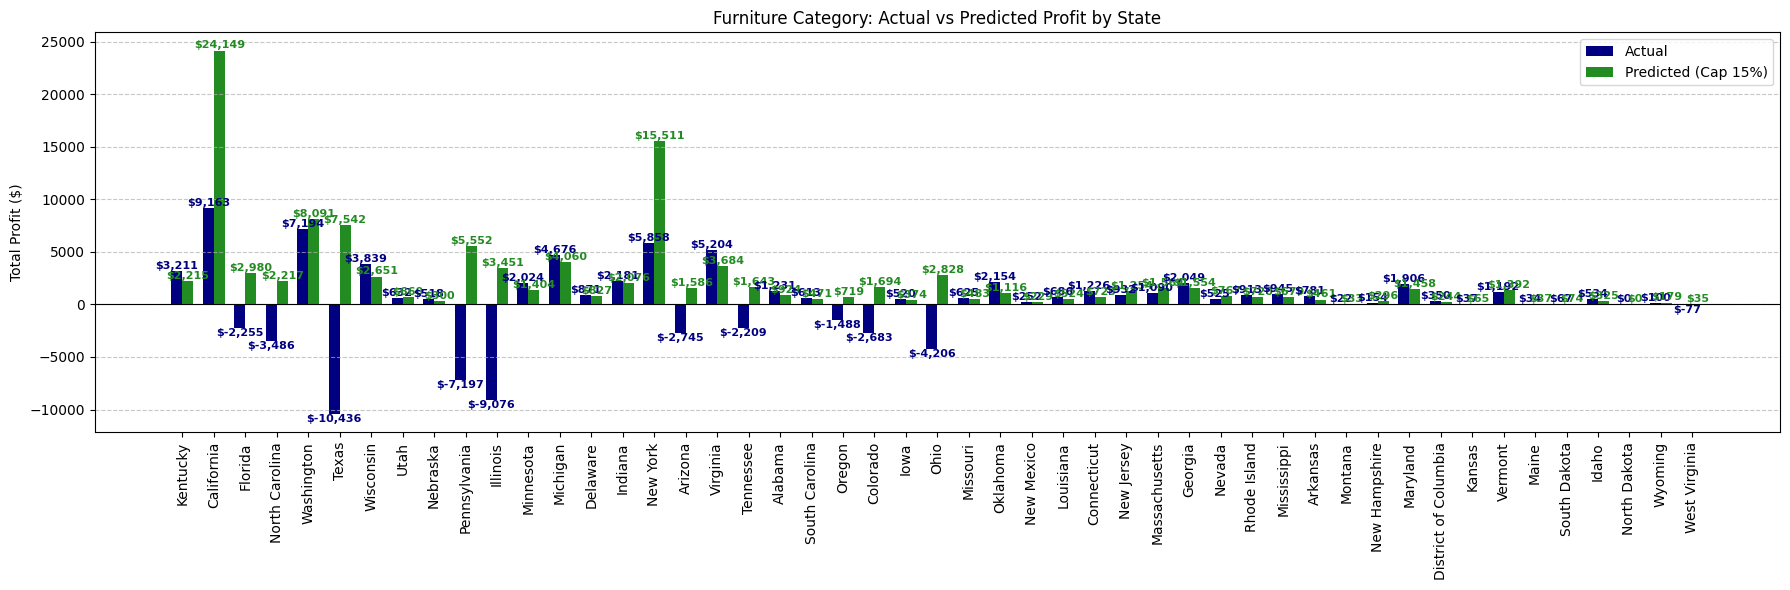

In [29]:
# Fist up, by State.

# Set discount level
discount_level = 0.15

# Set custom discount levels for our special target sub categories.
custom_overrides = {
    "Chairs": 0.1,
    "Bookcases": 0.1,
    "Supplies": 0.1,
    "Storage": 0.1,
    "Machines": 0.1
}

# Build full discount dictionary: apply overrides + fallback to discount_level
subcategories = df["Sub-Category"].unique()
custom_discounts = {
    subcat: custom_overrides.get(subcat, discount_level)
    for subcat in subcategories
}

# Get unique states
states = df["State"].unique()

# Store results
actual_profits = []
predicted_profits = []

for state in states:
    # Actual profit
    df_actual = df[(df["Category"] == "Furniture") & (df["State"] == state)]
    actual_profit = df_actual["Profit"].sum()
    actual_profits.append(actual_profit)

    # Predicted profit
    predicted = simulate_profit(
        df=df[df["State"] == state],
        trained_model=gb_model,
        model_features=X_train.columns.tolist(),
        category="Furniture",
        discount=custom_discounts
    )

    predicted_profits.append(predicted["Total Predicted Profit"] if "Total Predicted Profit" in predicted else 0)

# Plot
x = np.arange(len(states))
bar_width = 0.35

plt.figure(figsize=(18, 6))
bars1 = plt.bar(x - bar_width/2, actual_profits, width=bar_width, color="Navy", label="Actual")
bars2 = plt.bar(x + bar_width/2, predicted_profits, width=bar_width, color="ForestGreen", label=f"Predicted (Cap {int(discount_level*100)}%)")

# Labels
for i in range(len(states)):
    for bar, color in zip([bars1[i], bars2[i]], ["Navy", "ForestGreen"]):
        height = bar.get_height()
        offset = 5 if height >= 0 else -5
        va = 'bottom' if height >= 0 else 'top'
        plt.text(bar.get_x() + bar.get_width()/2, height + offset, f"${height:,.0f}",
                 ha='center', va=va, fontsize=8, color=color, fontweight="bold")

# Styling
plt.xticks(x, states, rotation=90)
plt.ylabel("Total Profit ($)")
plt.title("Furniture Category: Actual vs Predicted Profit by State")
plt.axhline(0, color='black', linewidth=0.8)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [30]:
# Once again, we see some profit making states making less profit than before based off our model, however, we know that the overall profits will be greater. This phenomenon might need further study.

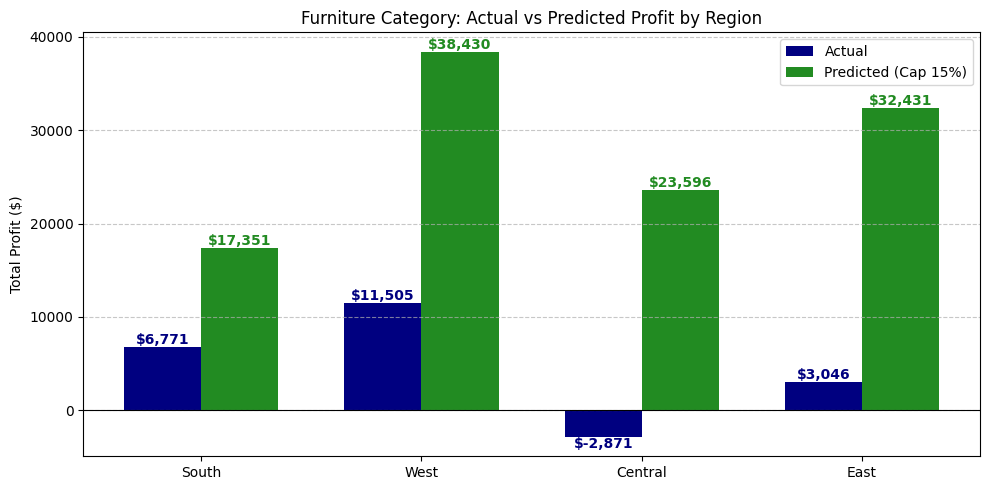

In [31]:
# Next up, Regions.
# Set discount level
discount_level = 0.15

# Set custom discount levels for our special target sub categories.
custom_overrides = {
    "Chairs": 0.1,
    "Bookcases": 0.1,
    "Supplies": 0.1,
    "Storage": 0.1,
    "Machines": 0.1
}

# Build full discount dictionary: apply overrides + fallback to discount_level
subcategories = df["Sub-Category"].unique()
custom_discounts = {
    subcat: custom_overrides.get(subcat, discount_level)
    for subcat in subcategories
}

# Get unique regions
regions = df["Region"].unique()

# Store results
actual_profits = []
predicted_profits = []

for region in regions:
    # Actual profit
    df_actual = df[(df["Category"] == "Furniture") & (df["Region"] == region)]
    actual_profit = df_actual["Profit"].sum()
    actual_profits.append(actual_profit)

    # Predicted profit
    predicted = simulate_profit(
        df=df[df["Region"] == region],
        trained_model=gb_model,
        model_features=X_train.columns.tolist(),
        category="Furniture",
        discount=custom_discounts
    )

    predicted_profits.append(predicted["Total Predicted Profit"] if "Total Predicted Profit" in predicted else 0)

# Plot
x = np.arange(len(regions))
bar_width = 0.35

plt.figure(figsize=(10, 5))
bars1 = plt.bar(x - bar_width/2, actual_profits, width=bar_width, color="Navy", label="Actual")
bars2 = plt.bar(x + bar_width/2, predicted_profits, width=bar_width, color="ForestGreen", label=f"Predicted (Cap {int(discount_level*100)}%)")

# Labels
for i in range(len(regions)):
    for bar, color in zip([bars1[i], bars2[i]], ["Navy", "ForestGreen"]):
        height = bar.get_height()
        offset = 5 if height >= 0 else -5
        va = 'bottom' if height >= 0 else 'top'
        plt.text(bar.get_x() + bar.get_width()/2, height + offset, f"${height:,.0f}",
                 ha='center', va=va, fontsize=10, color=color, fontweight="bold")

# Styling
plt.xticks(x, regions)
plt.ylabel("Total Profit ($)")
plt.title("Furniture Category: Actual vs Predicted Profit by Region")
plt.axhline(0, color='black', linewidth=0.8)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



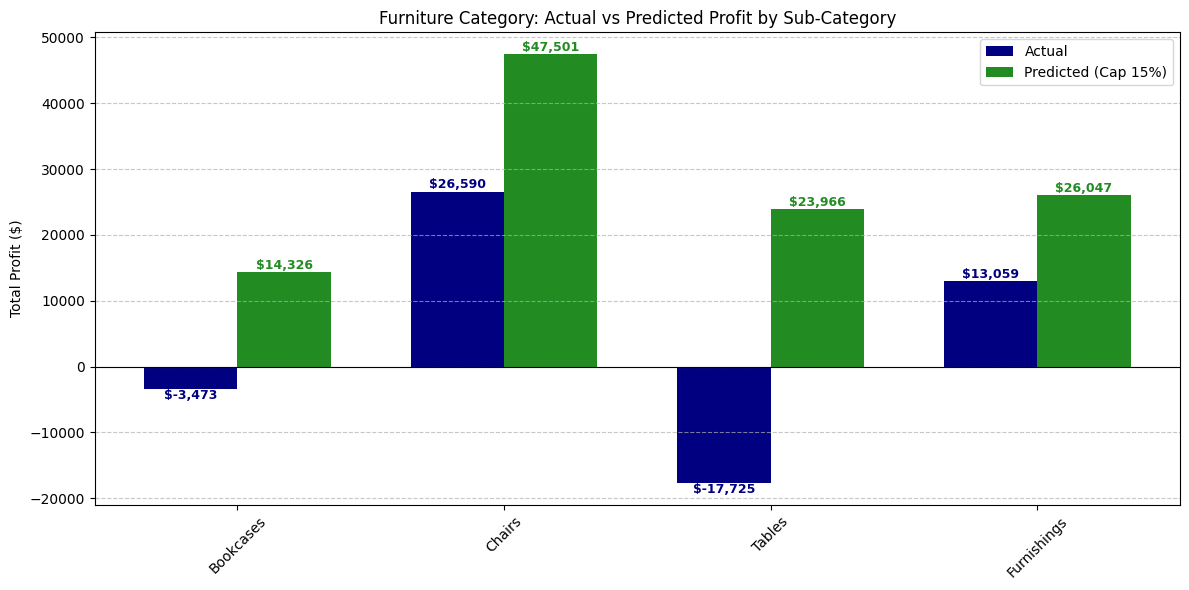

In [32]:
# Next up, Subcategories.
# Set discount level
discount_level = 0.15

# Set custom discount levels for our special target sub categories.
custom_overrides = {
    "Chairs": 0.1,
    "Bookcases": 0.15,
    "Supplies": 0.1,
    "Storage": 0.1,
    "Machines": 0.1
}

# Build full discount dictionary: apply overrides + fallback to discount_level
subcategories = df["Sub-Category"].unique()
custom_discounts = {
    subcat: custom_overrides.get(subcat, discount_level)
    for subcat in subcategories
}

# Get unique sub-categories under Furniture
furniture_subcats = df[df["Category"] == "Furniture"]["Sub-Category"].unique()

# Store results
actual_profits = []
predicted_profits = []

for subcat in furniture_subcats:
    # Actual profit
    df_actual = df[(df["Category"] == "Furniture") & (df["Sub-Category"] == subcat)]
    actual_profit = df_actual["Profit"].sum()
    actual_profits.append(actual_profit)

    # Predicted profit
    predicted = simulate_profit(
        df=df[df["Sub-Category"] == subcat],
        trained_model=gb_model,
        model_features=X_train.columns.tolist(),
        category="Furniture",
        sub_category=subcat,
        discount=custom_discounts
    )

    predicted_profits.append(predicted["Total Predicted Profit"] if "Total Predicted Profit" in predicted else 0)

# Plot
x = np.arange(len(furniture_subcats))
bar_width = 0.35

plt.figure(figsize=(12, 6))
bars1 = plt.bar(x - bar_width/2, actual_profits, width=bar_width, color="Navy", label="Actual")
bars2 = plt.bar(x + bar_width/2, predicted_profits, width=bar_width, color="ForestGreen", label=f"Predicted (Cap {int(discount_level*100)}%)")

# Labels
for i in range(len(furniture_subcats)):
    for bar, color in zip([bars1[i], bars2[i]], ["Navy", "ForestGreen"]):
        height = bar.get_height()
        offset = 5 if height >= 0 else -5
        va = 'bottom' if height >= 0 else 'top'
        plt.text(bar.get_x() + bar.get_width()/2, height + offset, f"${height:,.0f}",
                 ha='center', va=va, fontsize=9, color=color, fontweight="bold")

# Styling
plt.xticks(x, furniture_subcats, rotation=45)
plt.ylabel("Total Profit ($)")
plt.title("Furniture Category: Actual vs Predicted Profit by Sub-Category")
plt.axhline(0, color='black', linewidth=0.8)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



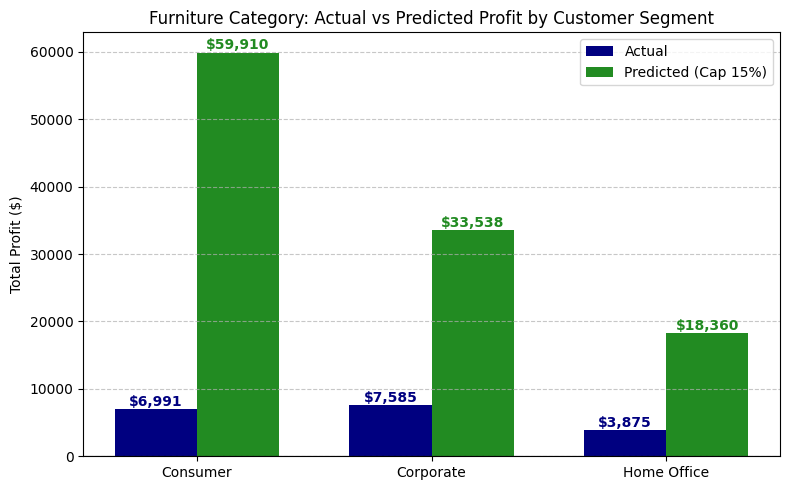

In [33]:
# And finally Segments.

# Set discount level
discount_level = 0.15

# Set custom discount levels for our special target sub categories.
custom_overrides = {
    "Chairs": 0.1,
    "Bookcases": 0.1,
    "Supplies": 0.1,
    "Storage": 0.1,
    "Machines": 0.1
}

# Build full discount dictionary: apply overrides + fallback to discount_level
subcategories = df["Sub-Category"].unique()
custom_discounts = {
    subcat: custom_overrides.get(subcat, discount_level)
    for subcat in subcategories
}

# Get unique segments
segments = df["Segment"].unique()

# Store results
actual_profits = []
predicted_profits = []

for segment in segments:
    # Actual profit
    df_actual = df[(df["Category"] == "Furniture") & (df["Segment"] == segment)]
    actual_profit = df_actual["Profit"].sum()
    actual_profits.append(actual_profit)

    # Predicted profit
    predicted = simulate_profit(
        df=df[df["Segment"] == segment],
        trained_model=gb_model,
        model_features=X_train.columns.tolist(),
        category="Furniture",
        Segment=segment,
        discount=custom_discounts
    )

    predicted_profits.append(predicted["Total Predicted Profit"] if "Total Predicted Profit" in predicted else 0)

# Plot
x = np.arange(len(segments))
bar_width = 0.35

plt.figure(figsize=(8, 5))
bars1 = plt.bar(x - bar_width/2, actual_profits, width=bar_width, color="Navy", label="Actual")
bars2 = plt.bar(x + bar_width/2, predicted_profits, width=bar_width, color="ForestGreen", label=f"Predicted (Cap {int(discount_level*100)}%)")

# Labels
for i in range(len(segments)):
    for bar, color in zip([bars1[i], bars2[i]], ["Navy", "ForestGreen"]):
        height = bar.get_height()
        offset = 5 if height >= 0 else -5
        va = 'bottom' if height >= 0 else 'top'
        plt.text(bar.get_x() + bar.get_width()/2, height + offset, f"${height:,.0f}",
                 ha='center', va=va, fontsize=10, color=color, fontweight="bold")

# Styling
plt.xticks(x, segments)
plt.ylabel("Total Profit ($)")
plt.title("Furniture Category: Actual vs Predicted Profit by Customer Segment")
plt.axhline(0, color='black', linewidth=0.8)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [34]:
# That's wraps it up for the Furniture category.

## OFFICE SUPPLIES________________________________________________________________________________________________________________

In [35]:
# Next up, a look at actual vs predicted profits in the Office Supplies Category by State, Region, Subcategory and Segment.

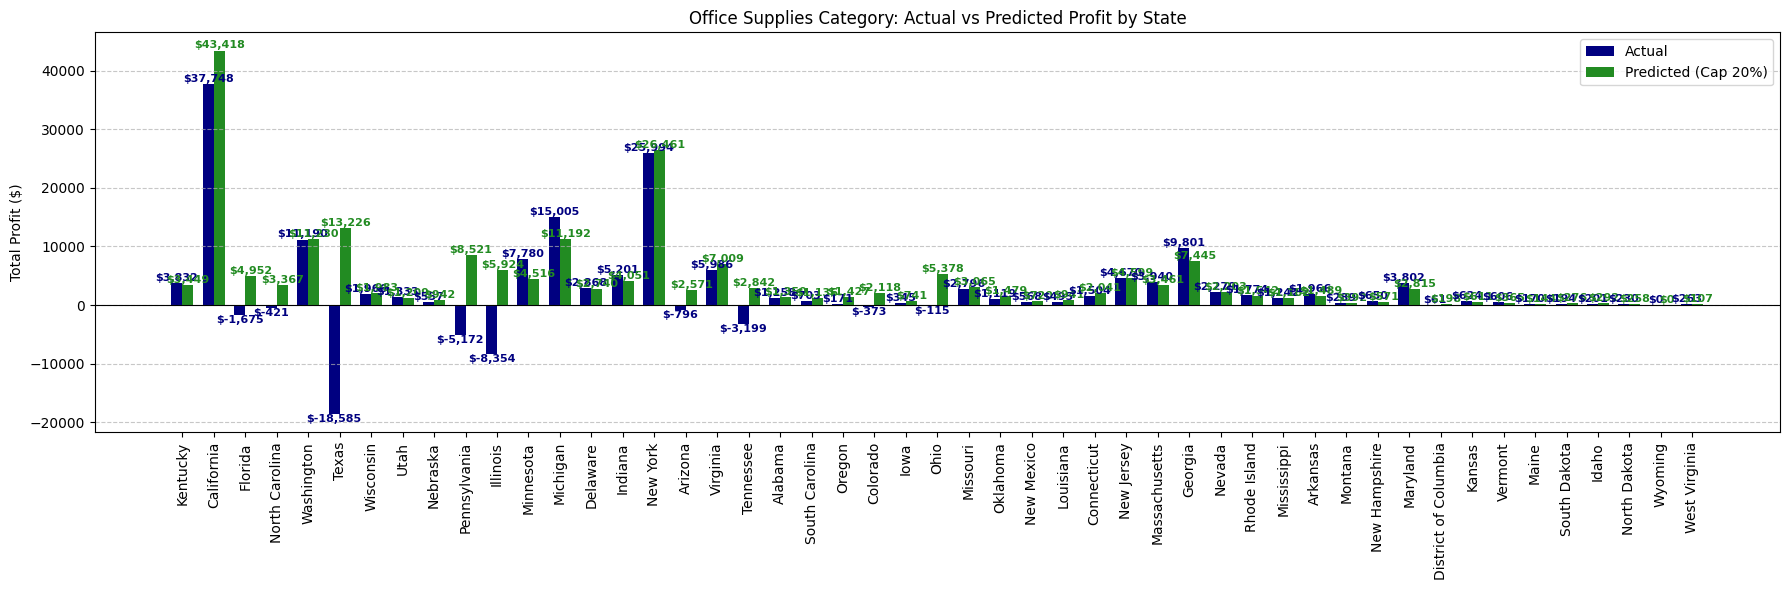

In [36]:
# Fist up, by State.

# Set discount level
discount_level = 0.2

# Set custom discount levels for our special target sub categories.
custom_overrides = {
    "Chairs": 0.1,
    "Bookcases": 0.1,
    "Appliances": 0.1,
    "Supplies": 0.1,
    "Storage": 0.1,
    "Machines": 0.1
}

# Build full discount dictionary: apply overrides + fallback to discount_level
subcategories = df["Sub-Category"].unique()
custom_discounts = {
    subcat: custom_overrides.get(subcat, discount_level)
    for subcat in subcategories
}

# Get unique states
states = df["State"].unique()

# Store results
actual_profits = []
predicted_profits = []

for state in states:
    # Actual profit
    df_actual = df[(df["Category"] == "Office Supplies") & (df["State"] == state)]
    actual_profit = df_actual["Profit"].sum()
    actual_profits.append(actual_profit)

    # Predicted profit
    predicted = simulate_profit(
        df=df[df["State"] == state],
        trained_model=gb_model,
        model_features=X_train.columns.tolist(),
        category="Office Supplies",
        discount=custom_discounts
    )

    predicted_profits.append(predicted["Total Predicted Profit"] if "Total Predicted Profit" in predicted else 0)

# Plot
x = np.arange(len(states))
bar_width = 0.35

plt.figure(figsize=(18, 6))
bars1 = plt.bar(x - bar_width/2, actual_profits, width=bar_width, color="Navy", label="Actual")
bars2 = plt.bar(x + bar_width/2, predicted_profits, width=bar_width, color="ForestGreen", label=f"Predicted (Cap {int(discount_level*100)}%)")

# Labels
for i in range(len(states)):
    for bar, color in zip([bars1[i], bars2[i]], ["Navy", "ForestGreen"]):
        height = bar.get_height()
        offset = 5 if height >= 0 else -5
        va = 'bottom' if height >= 0 else 'top'
        plt.text(bar.get_x() + bar.get_width()/2, height + offset, f"${height:,.0f}",
                 ha='center', va=va, fontsize=8, color=color, fontweight="bold")

# Styling
plt.xticks(x, states, rotation=90)
plt.ylabel("Total Profit ($)")
plt.title("Office Supplies Category: Actual vs Predicted Profit by State")
plt.axhline(0, color='black', linewidth=0.8)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [37]:
# Once again, we see some states falling below current profits off of this cap.

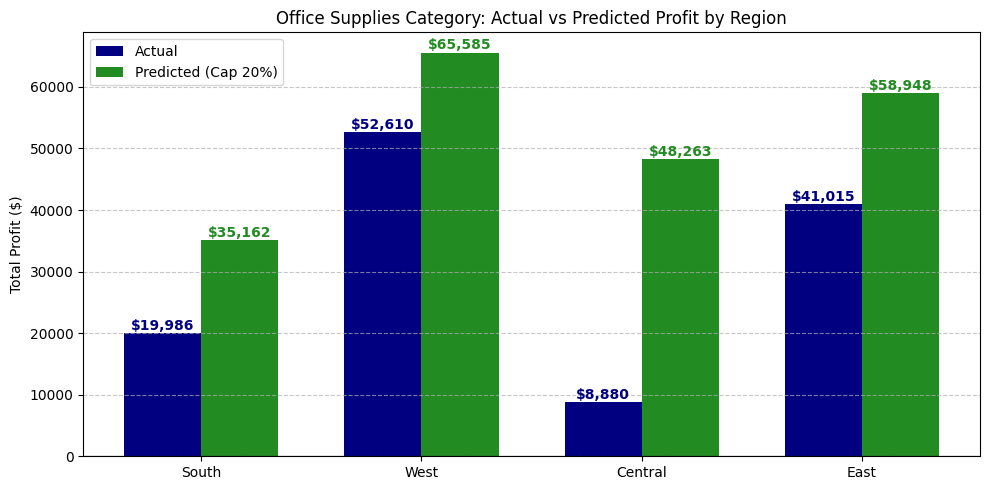

In [38]:
# Next up, Region.

# Set discount level
discount_level = 0.2

# Set custom discount levels for our special target sub categories.
custom_overrides = {
    "Chairs": 0.1,
    "Bookcases": 0.1,
    "Appliances": 0.1,
    "Supplies": 0.1,
    "Storage": 0.1,
    "Machines": 0.1
}

# Build full discount dictionary: apply overrides + fallback to discount_level
subcategories = df["Sub-Category"].unique()
custom_discounts = {
    subcat: custom_overrides.get(subcat, discount_level)
    for subcat in subcategories
}

# Get unique regions
regions = df["Region"].unique()

# Store results
actual_profits = []
predicted_profits = []

for region in regions:
    # Actual profit
    df_actual = df[(df["Category"] == "Office Supplies") & (df["Region"] == region)]
    actual_profit = df_actual["Profit"].sum()
    actual_profits.append(actual_profit)

    # Predicted profit
    predicted = simulate_profit(
        df=df[df["Region"] == region],
        trained_model=gb_model,
        model_features=X_train.columns.tolist(),
        category="Office Supplies",
        discount=custom_discounts
    )

    predicted_profits.append(predicted["Total Predicted Profit"] if "Total Predicted Profit" in predicted else 0)

# Plot
x = np.arange(len(regions))
bar_width = 0.35

plt.figure(figsize=(10, 5))
bars1 = plt.bar(x - bar_width/2, actual_profits, width=bar_width, color="Navy", label="Actual")
bars2 = plt.bar(x + bar_width/2, predicted_profits, width=bar_width, color="ForestGreen", label=f"Predicted (Cap {int(discount_level*100)}%)")

# Labels
for i in range(len(regions)):
    for bar, color in zip([bars1[i], bars2[i]], ["Navy", "ForestGreen"]):
        height = bar.get_height()
        offset = 5 if height >= 0 else -5
        va = 'bottom' if height >= 0 else 'top'
        plt.text(bar.get_x() + bar.get_width()/2, height + offset, f"${height:,.0f}",
                 ha='center', va=va, fontsize=10, color=color, fontweight="bold")

# Styling
plt.xticks(x, regions)
plt.ylabel("Total Profit ($)")
plt.title("Office Supplies Category: Actual vs Predicted Profit by Region")
plt.axhline(0, color='black', linewidth=0.8)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


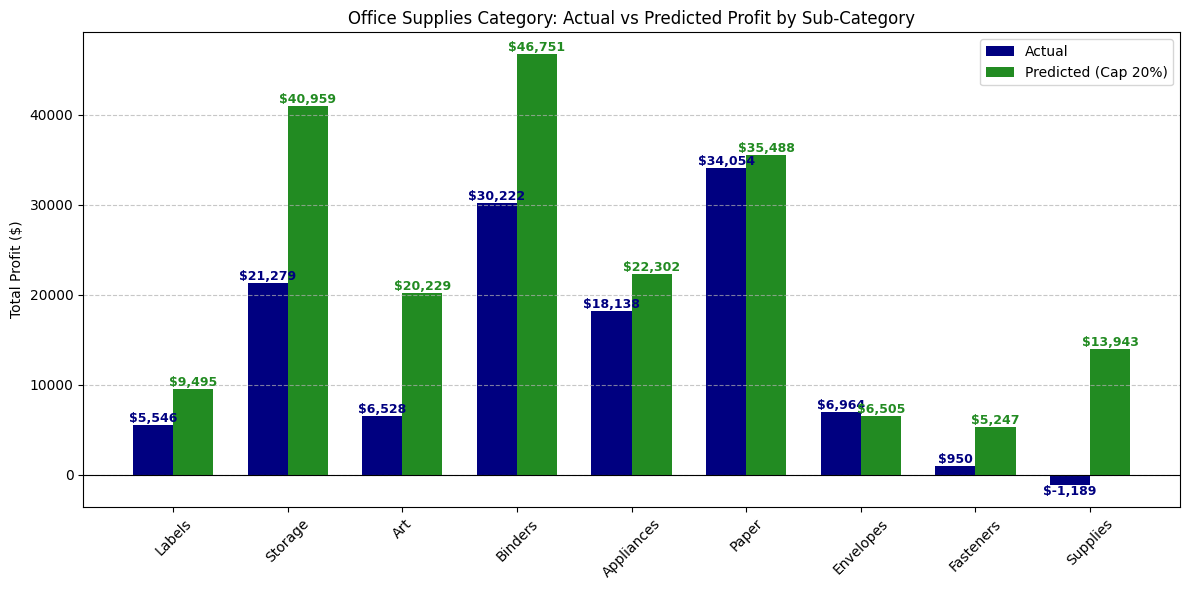

In [39]:
# Sub categories

# Set discount level
discount_level = 0.2

# Set custom discount levels for our special target sub categories.
custom_overrides = {
    "Chairs": 0.1,
    "Bookcases": 0.1,
    "Supplies": 0.1,
    "Storage": 0.1,
    "Appliances": 0.1,
    "Machines": 0.1
}

# Build full discount dictionary: apply overrides + fallback to discount_level
subcategories = df["Sub-Category"].unique()
custom_discounts = {
    subcat: custom_overrides.get(subcat, discount_level)
    for subcat in subcategories
}

# Get sub-categories within Office Supplies
subcats = df[df["Category"] == "Office Supplies"]["Sub-Category"].unique()

# Store results
actual_profits = []
predicted_profits = []

for subcat in subcats:
    # Actual profit
    df_actual = df[(df["Category"] == "Office Supplies") & (df["Sub-Category"] == subcat)]
    actual_profit = df_actual["Profit"].sum()
    actual_profits.append(actual_profit)

    # Predicted profit
    predicted = simulate_profit(
        df=df[df["Sub-Category"] == subcat],
        trained_model=gb_model,
        model_features=X_train.columns.tolist(),
        category="Office Supplies",
        sub_category=subcat,
        discount=custom_discounts
    )

    predicted_profits.append(predicted["Total Predicted Profit"] if "Total Predicted Profit" in predicted else 0)

# Plot
x = np.arange(len(subcats))
bar_width = 0.35

plt.figure(figsize=(12, 6))
bars1 = plt.bar(x - bar_width/2, actual_profits, width=bar_width, color="Navy", label="Actual")
bars2 = plt.bar(x + bar_width/2, predicted_profits, width=bar_width, color="ForestGreen", label=f"Predicted (Cap {int(discount_level*100)}%)")

# Labels
for i in range(len(subcats)):
    for bar, color in zip([bars1[i], bars2[i]], ["Navy", "ForestGreen"]):
        height = bar.get_height()
        offset = 5 if height >= 0 else -5
        va = 'bottom' if height >= 0 else 'top'
        plt.text(bar.get_x() + bar.get_width()/2, height + offset, f"${height:,.0f}",
                 ha='center', va=va, fontsize=9, color=color, fontweight="bold")

# Styling
plt.xticks(x, subcats, rotation=45)
plt.ylabel("Total Profit ($)")
plt.title("Office Supplies Category: Actual vs Predicted Profit by Sub-Category")
plt.axhline(0, color='black', linewidth=0.8)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


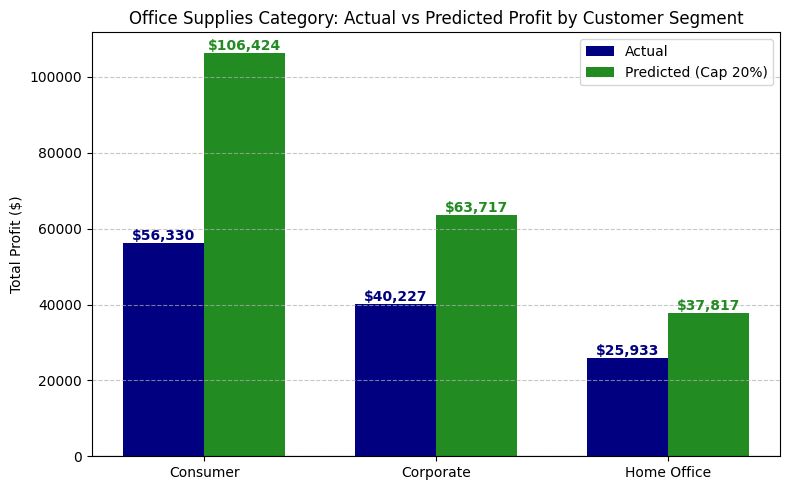

In [40]:
# Set discount level
discount_level = 0.2

# Set custom discount levels for our special target sub categories.
custom_overrides = {
    "Chairs": 0.1,
    "Bookcases": 0.1,
    "Supplies": 0.1,
    "Storage": 0.1,
    "Appliances": 0.1,
    "Machines": 0.1
}

# Build full discount dictionary: apply overrides + fallback to discount_level
subcategories = df["Sub-Category"].unique()
custom_discounts = {
    subcat: custom_overrides.get(subcat, discount_level)
    for subcat in subcategories
}

# Get unique customer segments
segments = df["Segment"].unique()

# Store results
actual_profits = []
predicted_profits = []

for segment in segments:
    # Actual profit
    df_actual = df[(df["Category"] == "Office Supplies") & (df["Segment"] == segment)]
    actual_profit = df_actual["Profit"].sum()
    actual_profits.append(actual_profit)

    # Predicted profit
    predicted = simulate_profit(
        df=df[df["Segment"] == segment],
        trained_model=gb_model,
        model_features=X_train.columns.tolist(),
        category="Office Supplies",
        Segment=segment,
        discount=custom_discounts
    )

    predicted_profits.append(predicted["Total Predicted Profit"] if "Total Predicted Profit" in predicted else 0)

# Plot
x = np.arange(len(segments))
bar_width = 0.35

plt.figure(figsize=(8, 5))
bars1 = plt.bar(x - bar_width/2, actual_profits, width=bar_width, color="Navy", label="Actual")
bars2 = plt.bar(x + bar_width/2, predicted_profits, width=bar_width, color="ForestGreen", label=f"Predicted (Cap {int(discount_level*100)}%)")

# Labels
for i in range(len(segments)):
    for bar, color in zip([bars1[i], bars2[i]], ["Navy", "ForestGreen"]):
        height = bar.get_height()
        offset = 5 if height >= 0 else -5
        va = 'bottom' if height >= 0 else 'top'
        plt.text(bar.get_x() + bar.get_width()/2, height + offset, f"${height:,.0f}",
                 ha='center', va=va, fontsize=10, color=color, fontweight="bold")

# Styling
plt.xticks(x, segments)
plt.ylabel("Total Profit ($)")
plt.title("Office Supplies Category: Actual vs Predicted Profit by Customer Segment")
plt.axhline(0, color='black', linewidth=0.8)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


## TECHNOLOGY________________________________________________________________________________________________________________________________________________________

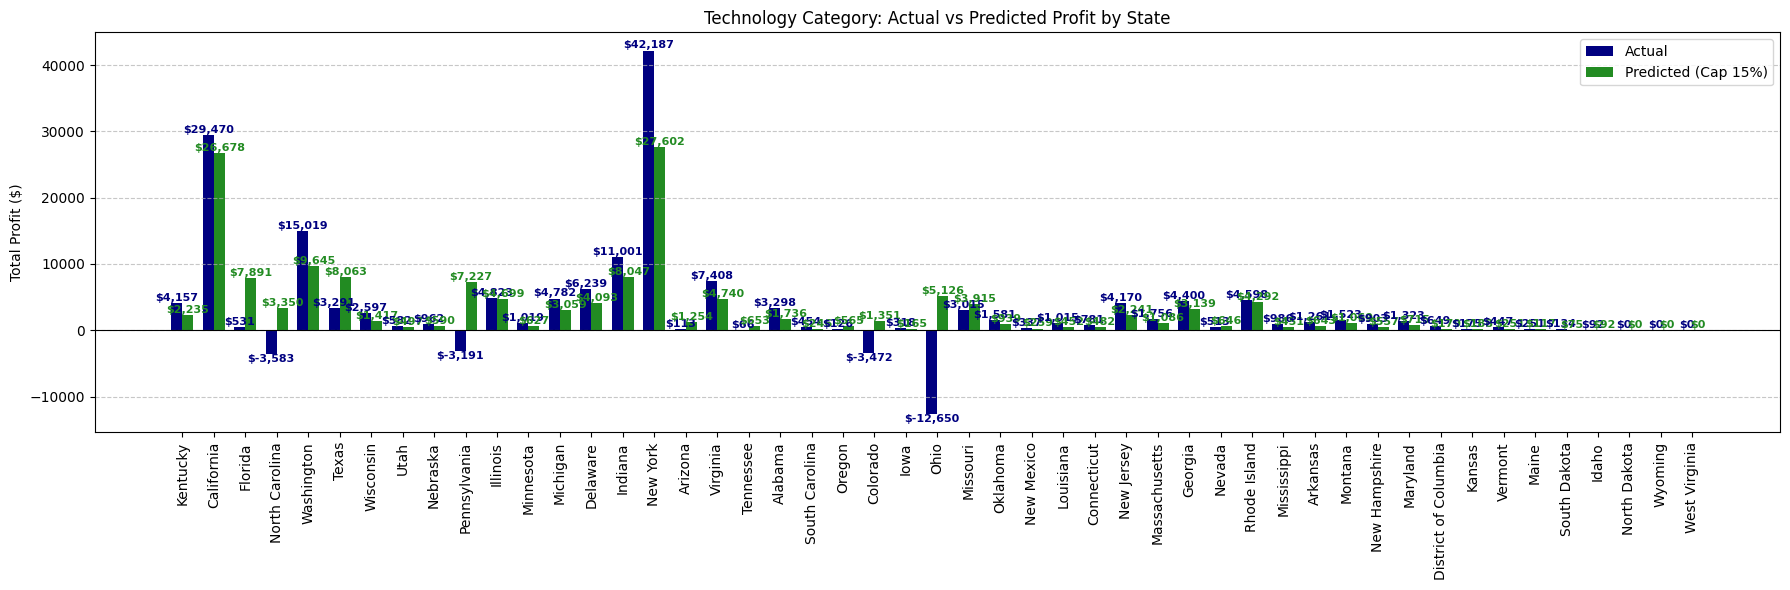

In [41]:
# Last up is Technology
# As usual, we'll start with the States.

# Set discount level
discount_level = 0.15

# Set custom discount levels for our special target sub categories.
custom_overrides = {
    "Chairs": 0.1,
    "Bookcases": 0.1,
    "Supplies": 0.1,
    "Storage": 0.1,
    "Appliances": 0.1,
    "Machines": 0.1
}

# Build full discount dictionary: apply overrides + fallback to discount_level
subcategories = df["Sub-Category"].unique()
custom_discounts = {
    subcat: custom_overrides.get(subcat, discount_level)
    for subcat in subcategories
}

# Get unique states
states = df["State"].unique()

# Store results
actual_profits = []
predicted_profits = []

for state in states:
    # Actual profit
    df_actual = df[(df["Category"] == "Technology") & (df["State"] == state)]
    actual_profit = df_actual["Profit"].sum()
    actual_profits.append(actual_profit)

    # Predicted profit
    predicted = simulate_profit(
        df=df[df["State"] == state],
        trained_model=gb_model,
        model_features=X_train.columns.tolist(),
        category="Technology",
        discount=custom_discounts
    )

    predicted_profits.append(predicted["Total Predicted Profit"] if "Total Predicted Profit" in predicted else 0)

# Plot
x = np.arange(len(states))
bar_width = 0.35

plt.figure(figsize=(18, 6))
bars1 = plt.bar(x - bar_width/2, actual_profits, width=bar_width, color="Navy", label="Actual")
bars2 = plt.bar(x + bar_width/2, predicted_profits, width=bar_width, color="ForestGreen", label=f"Predicted (Cap {int(discount_level*100)}%)")

# Labels
for i in range(len(states)):
    for bar, color in zip([bars1[i], bars2[i]], ["Navy", "ForestGreen"]):
        height = bar.get_height()
        offset = 5 if height >= 0 else -5
        va = 'bottom' if height >= 0 else 'top'
        plt.text(bar.get_x() + bar.get_width()/2, height + offset, f"${height:,.0f}",
                 ha='center', va=va, fontsize=8, color=color, fontweight="bold")

# Styling
plt.xticks(x, states, rotation=90)
plt.ylabel("Total Profit ($)")
plt.title("Technology Category: Actual vs Predicted Profit by State")
plt.axhline(0, color='black', linewidth=0.8)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()



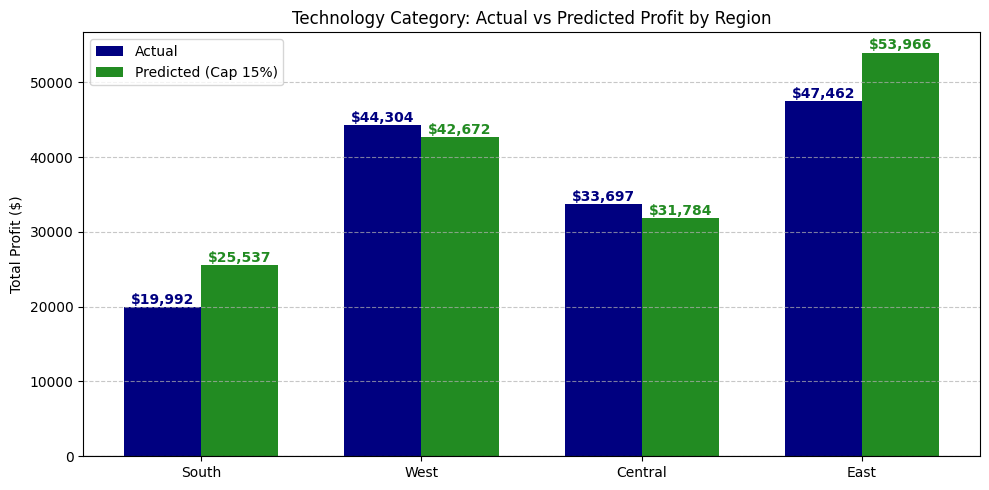

In [42]:
# Now by Region.

# Set discount level
discount_level = 0.15

# Set custom discount levels for our special target sub categories.
custom_overrides = {
    "Chairs": 0.1,
    "Bookcases": 0.1,
    "Supplies": 0.1,
    "Storage": 0.1,
    "Appliances": 0.1,
    "Machines": 0.1
}

# Build full discount dictionary: apply overrides + fallback to discount_level
subcategories = df["Sub-Category"].unique()
custom_discounts = {
    subcat: custom_overrides.get(subcat, discount_level)
    for subcat in subcategories
}

# Get unique regions
regions = df["Region"].unique()

# Store results
actual_profits = []
predicted_profits = []

for region in regions:
    # Actual profit
    df_actual = df[(df["Category"] == "Technology") & (df["Region"] == region)]
    actual_profit = df_actual["Profit"].sum()
    actual_profits.append(actual_profit)

    # Predicted profit
    predicted = simulate_profit(
        df=df[df["Region"] == region],
        trained_model=gb_model,
        model_features=X_train.columns.tolist(),
        category="Technology",
        discount=custom_discounts
    )

    predicted_profits.append(predicted["Total Predicted Profit"] if "Total Predicted Profit" in predicted else 0)

# Plot
x = np.arange(len(regions))
bar_width = 0.35

plt.figure(figsize=(10, 5))
bars1 = plt.bar(x - bar_width/2, actual_profits, width=bar_width, color="Navy", label="Actual")
bars2 = plt.bar(x + bar_width/2, predicted_profits, width=bar_width, color="ForestGreen", label=f"Predicted (Cap {int(discount_level*100)}%)")

# Labels
for i in range(len(regions)):
    for bar, color in zip([bars1[i], bars2[i]], ["Navy", "ForestGreen"]):
        height = bar.get_height()
        offset = 5 if height >= 0 else -5
        va = 'bottom' if height >= 0 else 'top'
        plt.text(bar.get_x() + bar.get_width()/2, height + offset, f"${height:,.0f}",
                 ha='center', va=va, fontsize=10, color=color, fontweight="bold")

# Styling
plt.xticks(x, regions)
plt.ylabel("Total Profit ($)")
plt.title("Technology Category: Actual vs Predicted Profit by Region")
plt.axhline(0, color='black', linewidth=0.8)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


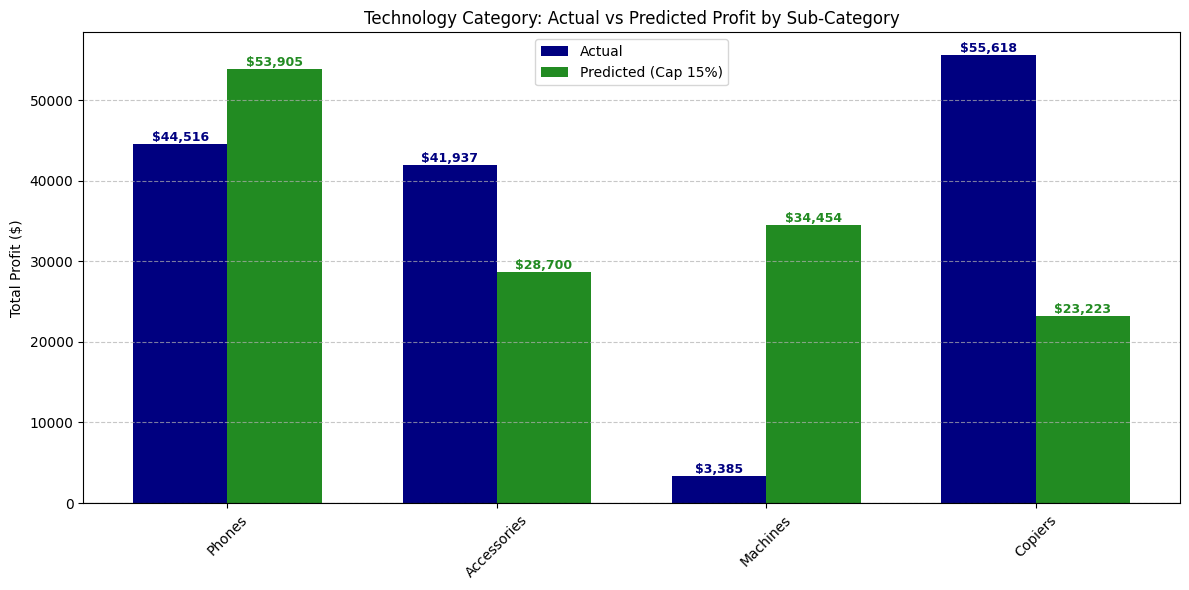

In [43]:
# Subcategories

# Set discount level
discount_level = 0.15

# Set custom discount levels for our special target sub categories.
custom_overrides = {
    "Phones": 0.1,
    "Accessories": 0.15,
    "Machines": 0.1,
    "Copiers": 0.15
}

# Build full discount dictionary: apply overrides + fallback to discount_level
subcategories = df["Sub-Category"].unique()
custom_discounts = {
    subcat: custom_overrides.get(subcat, discount_level)
    for subcat in subcategories
}

# Get unique sub-categories in Technology
subcats = df[df["Category"] == "Technology"]["Sub-Category"].unique()

# Store results
actual_profits = []
predicted_profits = []

for subcat in subcats:
    # Actual profit
    df_actual = df[(df["Category"] == "Technology") & (df["Sub-Category"] == subcat)]
    actual_profit = df_actual["Profit"].sum()
    actual_profits.append(actual_profit)

    # Predicted profit
    predicted = simulate_profit(
        df=df[df["Sub-Category"] == subcat],
        trained_model=gb_model,
        model_features=X_train.columns.tolist(),
        category="Technology",
        sub_category=subcat,
        discount=custom_discounts
    )

    predicted_profits.append(predicted["Total Predicted Profit"] if "Total Predicted Profit" in predicted else 0)

# Plot
x = np.arange(len(subcats))
bar_width = 0.35

plt.figure(figsize=(12, 6))
bars1 = plt.bar(x - bar_width/2, actual_profits, width=bar_width, color="Navy", label="Actual")
bars2 = plt.bar(x + bar_width/2, predicted_profits, width=bar_width, color="ForestGreen", label=f"Predicted (Cap {int(discount_level*100)}%)")

# Labels
for i in range(len(subcats)):
    for bar, color in zip([bars1[i], bars2[i]], ["Navy", "ForestGreen"]):
        height = bar.get_height()
        offset = 5 if height >= 0 else -5
        va = 'bottom' if height >= 0 else 'top'
        plt.text(bar.get_x() + bar.get_width()/2, height + offset, f"${height:,.0f}",
                 ha='center', va=va, fontsize=9, color=color, fontweight="bold")

# Styling
plt.xticks(x, subcats, rotation=45)
plt.ylabel("Total Profit ($)")
plt.title("Technology Category: Actual vs Predicted Profit by Sub-Category")
plt.axhline(0, color='black', linewidth=0.8)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


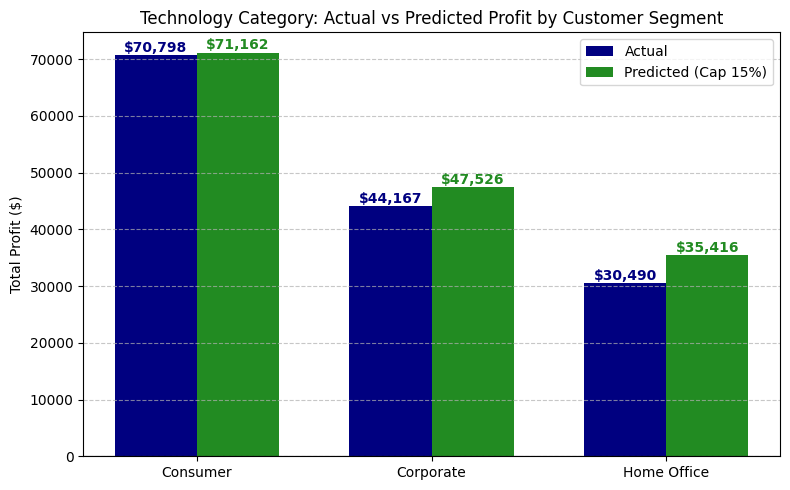

In [44]:
# Finally, by Segment.

# Set discount level
discount_level = 0.15

# Set custom discount levels for our special target sub categories.
custom_overrides = {
    "Chairs": 0.1,
    "Bookcases": 0.1,
    "Supplies": 0.1,
    "Storage": 0.1,
    "Appliances": 0.1,
    "Machines": 0.1,
    "Copiers": 0.1,
}

# Build full discount dictionary: apply overrides + fallback to discount_level
subcategories = df["Sub-Category"].unique()
custom_discounts = {
    subcat: custom_overrides.get(subcat, discount_level)
    for subcat in subcategories
}

# Get unique segments
segments = df["Segment"].unique()

# Store results
actual_profits = []
predicted_profits = []

for segment in segments:
    # Actual profit
    df_actual = df[(df["Category"] == "Technology") & (df["Segment"] == segment)]
    actual_profit = df_actual["Profit"].sum()
    actual_profits.append(actual_profit)

    # Predicted profit
    predicted = simulate_profit(
        df=df[df["Segment"] == segment],
        trained_model=gb_model,
        model_features=X_train.columns.tolist(),
        category="Technology",
        Segment=segment,
        discount=custom_discounts
    )

    predicted_profits.append(predicted["Total Predicted Profit"] if "Total Predicted Profit" in predicted else 0)

# Plot
x = np.arange(len(segments))
bar_width = 0.35

plt.figure(figsize=(8, 5))
bars1 = plt.bar(x - bar_width/2, actual_profits, width=bar_width, color="Navy", label="Actual")
bars2 = plt.bar(x + bar_width/2, predicted_profits, width=bar_width, color="ForestGreen", label=f"Predicted (Cap {int(discount_level*100)}%)")

# Labels
for i in range(len(segments)):
    for bar, color in zip([bars1[i], bars2[i]], ["Navy", "ForestGreen"]):
        height = bar.get_height()
        offset = 5 if height >= 0 else -5
        va = 'bottom' if height >= 0 else 'top'
        plt.text(bar.get_x() + bar.get_width()/2, height + offset, f"${height:,.0f}",
                 ha='center', va=va, fontsize=10, color=color, fontweight="bold")

# Styling
plt.xticks(x, segments)
plt.ylabel("Total Profit ($)")
plt.title("Technology Category: Actual vs Predicted Profit by Customer Segment")
plt.axhline(0, color='black', linewidth=0.8)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [45]:
joblib.dump(gb_model, "gb_model.pkl")


['gb_model.pkl']

In [46]:
# Report on Suggested Discount Caps

# Summary:
# The analysis of the suggested discount caps reveals the following key findings:
# 1. **Overall Profit Increase**:
#    - The predicted total profit with the suggested discount caps is significantly higher than the actual total profit.
#    - Actual Total Profit: $286,397.02
#    - Predicted Total Profit: $554,200.23
#    - This represents a substantial improvement in profitability.

# 2. **Category-Level Insights**:
#    - **Furniture**:
#      - While some states show a decrease in profit, the overall category profit increases significantly.
#      - Subcategories like "Chairs" and "Tables" benefit the most from the discount caps.
#    - **Office Supplies**:
#      - Similar trends are observed, with some states experiencing reduced profits but an overall increase in category profit.
#      - Subcategories like "Binders" and "Paper" show notable improvements.
#    - **Technology**:
#      - This category shows the highest improvement in profitability.
#      - Subcategories like "Phones" and "Accessories" benefit significantly from the discount caps.

# 3. **Regional Insights**:
#    - All regions show an increase in predicted profits.
#    - Loss-making regions are turned into profit-making regions under the suggested discount caps.

# 4. **Customer Segment Insights**:
#    - All customer segments (Consumer, Corporate, Home Office) show improved profitability.
#    - The "Home Office" segment benefits the most from the discount caps.

# 5. **State-Level Insights**:
#    - While some profit-making states show reduced profits, loss-making states see significant improvements.
#    - This indicates a redistribution of profitability across states.

# Recommendations:
# - Implement the suggested discount caps to maximize overall profitability.
# - Conduct further analysis on states and subcategories where profits decrease to identify potential adjustments.
# - Monitor the impact of the discount caps on customer behavior and sales volume to ensure long-term sustainability.